In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from timeseries import *
from models import *
import pickle 
import numpy as np
from sklearn.model_selection import train_test_split
from fastai.distributed import *

/opt/anaconda/envs/pytorch/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [3]:
x, y = pickle.load(open("data/train.pkl", "rb"))

In [4]:
test_name, x_test = pickle.load(open("data/test.pkl", "rb"))

In [5]:
x.mean(), x.std(), x.min(), x.max()

(-6.63823368281504e-06, 79.22496224741775, -5831.451171875, 6120.92822265625)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
scale_type = 'normalize'
scale_by_channel = False
scale_by_sample  = True 
scale_range = (-1, 1)
bs = 32

In [8]:
data = (ItemLists(Path("data"), TSList(x_train),TSList(x_val))
        .label_from_lists(y_train, y_val)
        .databunch(bs=bs, val_bs=bs * 2)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
     )
data

TSDataBunch;

Train: LabelList (512 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,2,2,1
Path: .;

Valid: LabelList (128 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,2,2,2
Path: .;

Test: None

In [12]:
data.train_ds

LabelList (512 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,2,2,1
Path: .

In [15]:
data.train_dl.dl.sampler

In [10]:
data.valid_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f74d6732cd0>, device=device(type='cuda'), tfms=[], collate_fn=<function data_collate at 0x7f7457eee3b0>)

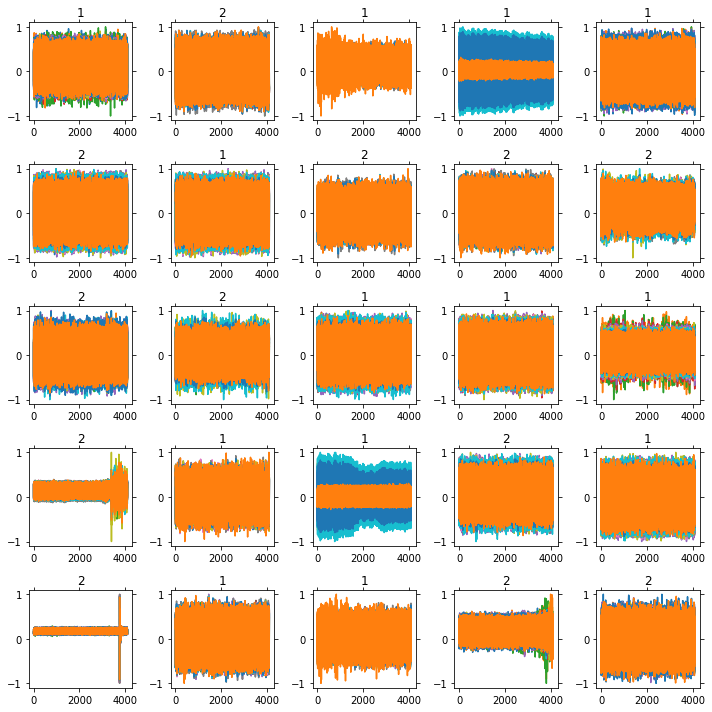

In [9]:
data.show_batch()

In [9]:
def TS_geometric_tfms(**kwargs):
    return [[
        TStimewarp(**kwargs),
        TSmagwarp(**kwargs),
        TStimenoise(**kwargs),
        TSmagnoise(**kwargs),
        TSmagscale(**kwargs),
        TSdimmagscale(**kwargs),
        TSzoomin(**kwargs),
        TSzoomout(**kwargs),
        TSrandomzoom(**kwargs),
        TSrandtimestep(**kwargs),
    ], []]


def TS_erasing_tfms(**kwargs):
    return [[
        
        TSdimout(**kwargs),
        TScutout(**kwargs),
        TStimestepzero(**kwargs),
        TScrop(**kwargs),
        TSrandomcrop(**kwargs),
        TSmaskout(**kwargs)
    ], []]


def TS_tfms(**kwargs):
    return [TS_geometric_tfms(**kwargs)[0] + TS_erasing_tfms(**kwargs)[0], []]


def all_TS_tfms(**kwargs):
    return [TS_tfms(**kwargs)[0] + 
            [TStimestepout(**kwargs), TSlookback(**kwargs), TScentercrop(**kwargs)], 
            []]

In [11]:
model = ResNet(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).randaugment()

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.732965,0.699899,0.492188,0.000000,00:03
1,0.715217,0.707976,0.507812,0.000000,00:04
2,0.702946,0.738406,0.523438,0.034619,00:03
3,0.694499,0.697752,0.523438,0.035573,00:02
4,0.692586,0.682029,0.570312,0.147287,00:02
5,0.686264,0.684447,0.562500,0.114843,00:03
6,0.676744,0.840331,0.562500,0.133253,00:02
7,0.681652,0.835799,0.531250,0.050680,00:02
8,0.693911,1.669861,0.507812,0.030303,00:03
9,0.697552,2.003561,0.515625,0.044546,00:02


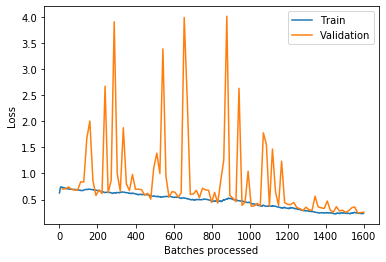

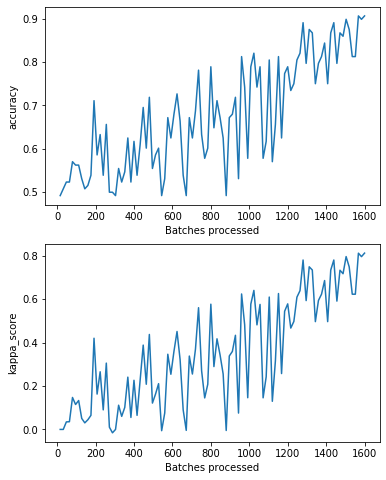

In [12]:
learn.fit_one_cycle(100)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [13]:
learn.save("resnet-randaugment-relu-step-1")

In [14]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


# Can we fit all the data in memory ?

In [15]:
scale_type = 'normalize'
scale_by_channel = False
scale_by_sample  = True 
scale_range = (-1, 1)
bs = 256

In [16]:
data = (ItemLists(Path("data"), TSList(x_train),TSList(x_val))
        .label_from_lists(y_train, y_val)
        .databunch(bs=bs, val_bs=128)
        .scale(scale_type=scale_type, scale_by_channel=scale_by_channel, 
             scale_by_sample=scale_by_sample,scale_range=scale_range)
     )
data

TSDataBunch;

Train: LabelList (512 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,2,2,1
Path: .;

Valid: LabelList (128 items)
x: TSList
TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096),TimeSeries(ch=12, seq_len=4096)
y: CategoryList
1,2,2,2,2
Path: .;

Test: None

In [16]:
data.c

2

In [17]:
data.features

12

In [18]:
model = ResNet(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).randaugment().to_parallel()

In [19]:
learn.fit_one_cycle(100)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.745441,0.698982,0.492188,0.000000,00:06
1,0.721097,0.700726,0.492188,0.000000,00:01
2,0.708507,0.699747,0.492188,0.000000,00:01
3,0.703808,0.698187,0.492188,0.000000,00:02
4,0.696904,0.697127,0.492188,0.000000,00:01
5,0.692860,0.698103,0.492188,0.000000,00:01
6,0.688573,0.696221,0.492188,0.000000,00:02
7,0.684741,0.694970,0.492188,0.000000,00:04
8,0.679187,0.693818,0.484375,-0.024000,00:01
9,0.672693,0.701843,0.507812,0.000000,00:04


In [22]:
learn.save("resnet-randaugment")

this object has been destroyed


In [23]:
learn.destroy()

this object has been destroyed


In [24]:
model = ResNet(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).randaugment(N=2).to_parallel()

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.723574,0.693387,0.507812,0.000000,00:07
1,0.711760,0.693538,0.507812,0.000000,00:05
2,0.704327,0.693740,0.507812,0.000000,00:05
3,0.700329,0.694065,0.507812,0.000000,00:02
4,0.696990,0.694188,0.507812,0.000000,00:09
5,0.694586,0.694739,0.507812,0.000000,00:07
6,0.691307,0.696587,0.507812,0.000000,00:04
7,0.689551,0.696781,0.507812,0.000000,00:05
8,0.689322,0.696598,0.515625,0.016605,00:02
9,0.686243,0.696644,0.515625,0.017579,00:05


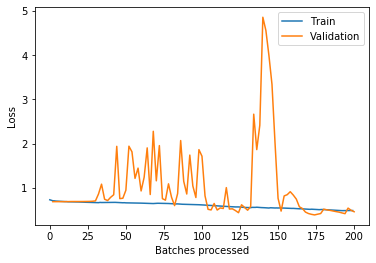

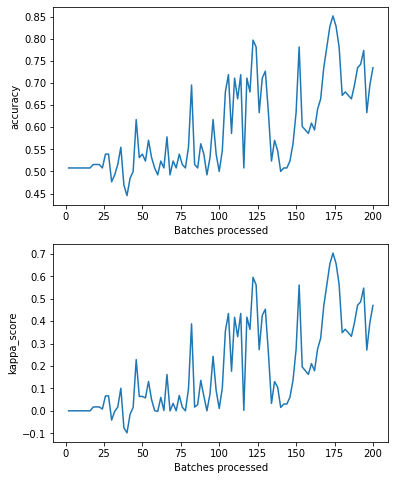

In [25]:
learn.fit_one_cycle(100)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [26]:
learn.save("resnet-randaugment-N2")
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [27]:
model = ResNet(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).randaugment(N=3).to_parallel()

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.699927,0.693645,0.507812,0.000000,00:06
1,0.700794,0.694015,0.507812,0.000000,00:05
2,0.699866,0.694696,0.507812,0.000000,00:05
3,0.698005,0.695331,0.507812,0.000000,00:07
4,0.695747,0.695417,0.507812,0.000000,00:04
5,0.691497,0.695670,0.507812,0.000000,00:09
6,0.688995,0.695973,0.507812,0.000000,00:04
7,0.686880,0.696148,0.515625,0.016117,00:01
8,0.682289,0.699938,0.507812,0.000000,00:05
9,0.681885,0.712212,0.507812,0.000000,00:11


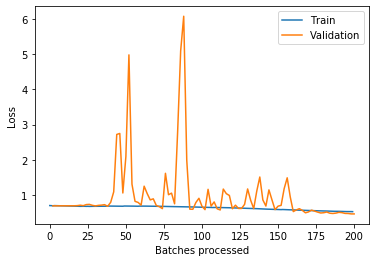

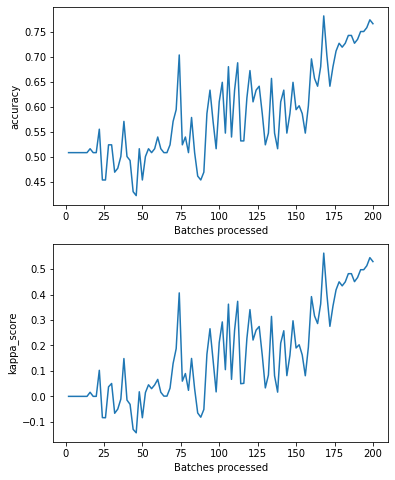

In [28]:
learn.fit_one_cycle(100)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [29]:
learn.save("resnet-randaugment-N3")
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


# ResNet with Weighted Pooling

In [30]:
model = ResNet(data.features, data.c, pool=WeightedAdataptivePooling1d).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).randaugment().to_parallel()

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,1.535333,0.697527,0.492188,0.000000,00:04
1,1.198197,0.698654,0.492188,0.000000,00:01
2,1.061110,0.701713,0.492188,0.000000,00:04
3,0.980563,0.706760,0.492188,0.000000,00:01
4,0.927204,0.712740,0.492188,0.000000,00:04
5,0.909305,0.718384,0.492188,0.000000,00:02
6,0.886071,0.719029,0.492188,0.000000,00:02
7,0.859592,0.709067,0.492188,0.000000,00:01
8,0.839450,0.702026,0.492188,0.000000,00:01
9,0.826474,0.702540,0.507812,0.029836,00:02


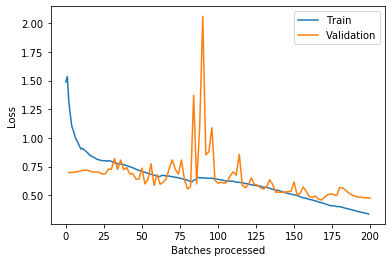

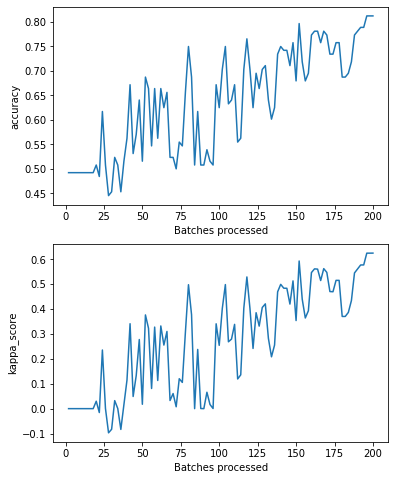

In [31]:
learn.fit_one_cycle(100)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [32]:
learn.save("resnetwp-randaugment")
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [33]:
model = ResNet(data.features, data.c, pool=WeightedAdataptivePooling1d).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).randaugment(N=2).to_parallel()

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.764291,0.694820,0.492188,0.000000,00:04
1,0.734062,0.694973,0.492188,0.000000,00:01
2,0.710615,0.694212,0.492188,0.000000,00:03
3,0.696570,0.693638,0.492188,0.000000,00:05
4,0.700119,0.693216,0.492188,0.000000,00:05
5,0.691272,0.692775,0.492188,0.000000,00:03
6,0.694283,0.692213,0.492188,0.000000,00:07
7,0.702058,0.691688,0.500000,0.012298,00:07
8,0.706897,0.693969,0.484375,-0.015629,00:07
9,0.712766,0.690111,0.554688,0.103685,00:07


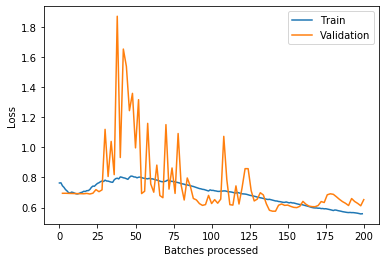

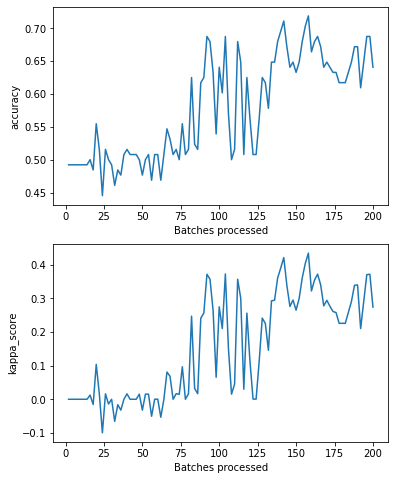

In [34]:
learn.fit_one_cycle(100)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [35]:
learn.save("resnetwp-randaugment-N2")
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [36]:
model = ResNet(data.features, data.c, pool=WeightedAdataptivePooling1d).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).randaugment(N=3).to_parallel()

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.905535,0.693723,0.507812,0.000000,00:05
1,0.836839,0.694506,0.507812,0.000000,00:05
2,0.883018,0.696534,0.507812,0.000000,00:05
3,0.854808,0.697776,0.507812,0.000000,00:04
4,0.852100,0.696926,0.507812,0.000000,00:02
5,0.827296,0.695017,0.507812,0.000000,00:06
6,0.827604,0.693485,0.507812,0.000000,00:04
7,0.811695,0.692983,0.507812,0.000000,00:05
8,0.799206,0.692922,0.500000,-0.015621,00:05
9,0.784827,0.692079,0.507812,0.002967,00:05


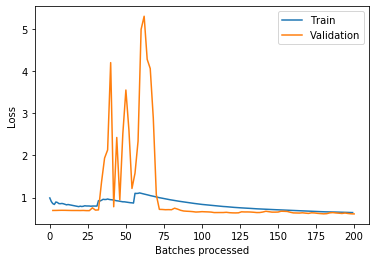

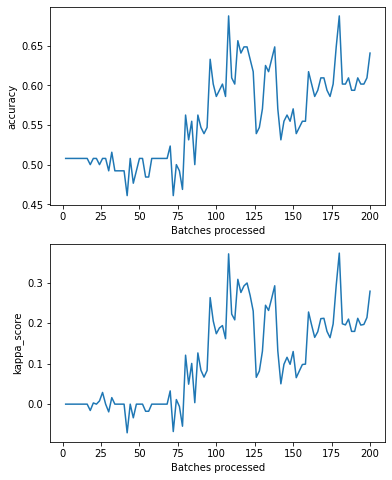

In [37]:
learn.fit_one_cycle(100)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [38]:
learn.save("resnetwp-randaugment-N3")
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


# ResNet with Simple Attention

In [22]:
model = ResNetSA(data.features, data.c).to(device)
kappa = KappaScore()
loss_func=LabelSmoothingCrossEntropy()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy, kappa])

In [23]:
# learn.fit_one_cycle(100)

# ResNet with Simple Attention and Temporal Attention

In [24]:
model = ResNetSA(data.features, data.c, temporal=True).to(device)
kappa = KappaScore()
loss_func=LabelSmoothingCrossEntropy()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy, kappa])

In [25]:
# learn.fit_one_cycle(100)

# ResNext

In [26]:
model = ResNeXt(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [27]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.699653,0.693311,0.492188,0.000000,00:02
1,0.684357,0.692944,0.554688,0.099259,00:02
2,0.672751,0.692838,0.507812,0.000000,00:02
3,0.660344,0.693001,0.507812,0.000000,00:02
4,0.647185,0.693756,0.507812,0.000000,00:02
5,0.634403,0.697617,0.507812,0.000000,00:02
6,0.618907,0.709475,0.507812,0.000000,00:02
7,0.604789,0.756427,0.507812,0.000000,00:02
8,0.595711,0.852650,0.507812,0.000000,00:02
9,0.583796,1.017536,0.507812,0.000000,00:02


# ResNext WAD

In [29]:
model = ResNeXt(data.features, data.c, pool=WeightedAdataptivePooling1d).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [30]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,1.975695,0.693734,0.492188,0.000000,00:02
1,1.425890,0.695174,0.492188,0.000000,00:02
2,1.234308,0.700390,0.492188,0.000000,00:03
3,1.087925,0.706525,0.492188,0.000000,00:03
4,0.983937,0.709911,0.492188,0.000000,00:03
5,0.909281,0.709296,0.492188,0.000000,00:03
6,0.833481,0.706631,0.492188,0.000000,00:02
7,0.774863,0.702255,0.492188,0.000000,00:02
8,0.721455,0.698764,0.492188,0.000000,00:02
9,0.669749,0.695888,0.476562,-0.031761,00:02


# InceptionTime

In [31]:
model = InceptionTime(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [32]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.714809,0.693984,0.507812,0.000000,00:01
1,0.705855,0.693992,0.507812,0.000000,00:01
2,0.699263,0.693896,0.507812,0.000000,00:01
3,0.692006,0.693781,0.507812,0.000000,00:01
4,0.686037,0.693744,0.507812,0.000000,00:01
5,0.681029,0.693817,0.507812,0.000000,00:01
6,0.675045,0.693867,0.507812,0.000000,00:01
7,0.669252,0.694001,0.507812,0.000000,00:01
8,0.666134,0.694392,0.507812,0.000000,00:01
9,0.663836,0.694424,0.507812,0.000000,00:01


In [33]:
learn.save("inception-parallel")

In [34]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


# ResCNN

In [35]:
model = ResCNN(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [36]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.793387,0.693121,0.507812,0.000000,00:01
1,0.782850,0.693189,0.492188,-0.003861,00:01
2,0.773822,0.693445,0.492188,0.000000,00:01
3,0.764631,0.693840,0.492188,0.000000,00:01
4,0.755540,0.694082,0.492188,0.000000,00:01
5,0.746010,0.694318,0.492188,0.000000,00:01
6,0.737005,0.694959,0.492188,0.000000,00:01
7,0.727948,0.695313,0.492188,0.000000,00:01
8,0.720347,0.694781,0.507812,0.027965,00:01
9,0.712340,0.692560,0.570312,0.143135,00:01


In [37]:
learn.save("rescnn-parallel")

In [38]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


# FCN

In [39]:
model = FCN(data.features, data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [40]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.709862,0.694330,0.492188,0.000000,00:01
1,0.704178,0.694798,0.492188,0.000000,00:01
2,0.700660,0.695512,0.492188,0.000000,00:01
3,0.697008,0.696638,0.492188,0.000000,00:01
4,0.694794,0.697570,0.492188,0.000000,00:01
5,0.691592,0.696943,0.492188,-0.001444,00:01
6,0.689435,0.696448,0.445312,-0.095996,00:01
7,0.687391,0.698320,0.445312,-0.096525,00:01
8,0.685641,0.699022,0.476562,-0.037252,00:01
9,0.683590,0.695493,0.500000,0.004133,00:01


In [41]:
learn.save("fcn-parallel")

In [42]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


# Wide ResNet

In [43]:
model = WideResNet(n_in_channels=data.features, num_classes=data.c).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [44]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.693978,0.693017,0.507812,0.027496,00:01
1,0.694016,0.693009,0.500000,0.012774,00:01
2,0.693950,0.692981,0.500000,0.012774,00:01
3,0.693902,0.692920,0.500000,0.012774,00:01
4,0.693875,0.692859,0.500000,0.012774,00:01
5,0.693837,0.692789,0.500000,0.012298,00:01
6,0.693784,0.692723,0.500000,0.011821,00:01
7,0.693729,0.692673,0.515625,0.041314,00:01
8,0.693651,0.692631,0.492188,-0.006776,00:01
9,0.693587,0.692603,0.492188,-0.009709,00:01


# Wide ResNet22

In [45]:
model = WideResNet(n_in_channels=data.features, num_classes=data.c, num_groups=3, N=3, k=6, drop_p=0.).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [46]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.704373,0.692916,0.539062,0.069492,00:02
1,0.698297,0.693079,0.507812,0.000000,00:02
2,0.693405,0.692992,0.507812,0.000000,00:02
3,0.689065,0.693028,0.500000,-0.015621,00:02
4,0.684884,0.693119,0.507812,0.001486,00:02
5,0.680400,0.692972,0.507812,0.001486,00:02
6,0.675965,0.692099,0.500000,-0.013109,00:02
7,0.670748,0.690292,0.515625,0.018551,00:02
8,0.665198,0.684566,0.523438,0.035573,00:02
9,0.659263,0.677577,0.539062,0.067194,00:02


# Xception

In [47]:
model = xception(data.c, in_channels=data.features).to(device)
kappa = KappaScore()
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()

In [48]:
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.757142,0.693597,0.492188,0.000000,00:01
1,0.695077,0.693577,0.492188,0.000000,00:01
2,0.666656,0.693767,0.492188,0.000000,00:01
3,0.644065,0.694720,0.492188,0.000000,00:01
4,0.612924,0.697821,0.492188,0.000000,00:01
5,0.573940,0.712661,0.492188,0.000000,00:01
6,0.537144,0.747558,0.492188,0.000000,00:01
7,0.512039,0.729416,0.492188,0.000000,00:01
8,0.563485,0.824681,0.492188,0.000000,00:01
9,0.550062,0.819955,0.492188,0.000000,00:01


# Rocket

## Normalize data 'per sample'

In [49]:
eps = 1e-6
x_train = (x_train - x_train.mean(axis=(1, 2), keepdims=True)) / ( x_train.std(axis=(1, 2), keepdims=True) + eps)
x_val = (x_val - x_val.mean(axis=(1, 2), keepdims=True)) / ( x_val.std(axis=(1, 2), keepdims=True) + eps)

In [50]:
x_train.shape

(512, 12, 4096)

## calculate features

In [51]:
_, features, seq_len = x_train.shape
model = ROCKET(features, seq_len, n_kernels=10000, kss=[7, 9, 11]).to(device)
x_train_tfm = model(torch.tensor(x_train, device=device).float())
x_valid_tfm = model(torch.tensor(x_val, device=device).float())

In [52]:
x_train_tfm.shape

torch.Size([512, 20000])

## Normalize 'per feature'

In [53]:
f_mean = x_train_tfm.mean(dim=0, keepdims=True)
f_std = x_train_tfm.std(dim=0, keepdims=True) + eps
x_train_tfm_norm = (x_train_tfm - f_mean) / f_std
x_valid_tfm_norm = (x_valid_tfm - f_mean) / f_std

In [54]:
data = (ItemLists('.', TSList(x_train_tfm_norm), TSList(x_valid_tfm_norm))
        .label_from_lists(y_train, y_val)
        .databunch(bs=64, val_bs=min(bs * 2, len(x_val)))
       )
data

TSDataBunch;

Train: LabelList (512 items)
x: TSList
TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000)
y: CategoryList
1,2,2,2,1
Path: .;

Valid: LabelList (128 items)
x: TSList
TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000),TimeSeries(ch=1, seq_len=20000)
y: CategoryList
1,2,2,2,2
Path: .;

Test: None

In [55]:
model = ResNet(data.features, data.c).to(device)
learn = Learner(data, model, metrics=[accuracy, kappa]).to_fp16().to_parallel()
learn.fit_one_cycle(100)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.762077,0.698415,0.507812,0.000000,00:04
1,0.738201,0.699824,0.468750,-0.052479,00:04
2,0.724262,0.700020,0.460938,-0.068732,00:03
3,0.715176,0.703671,0.500000,0.012298,00:03
4,0.708836,0.710942,0.546875,0.104031,00:03
5,0.704917,0.687689,0.593750,0.193212,00:03
6,0.701661,0.686329,0.585938,0.180676,00:03
7,0.699458,0.721611,0.554688,0.114563,00:03
8,0.696583,0.705803,0.554688,0.117988,00:03
9,0.697492,0.705326,0.609375,0.225369,00:03


In [56]:
learn.save("resnet-rocket")

In [57]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable
